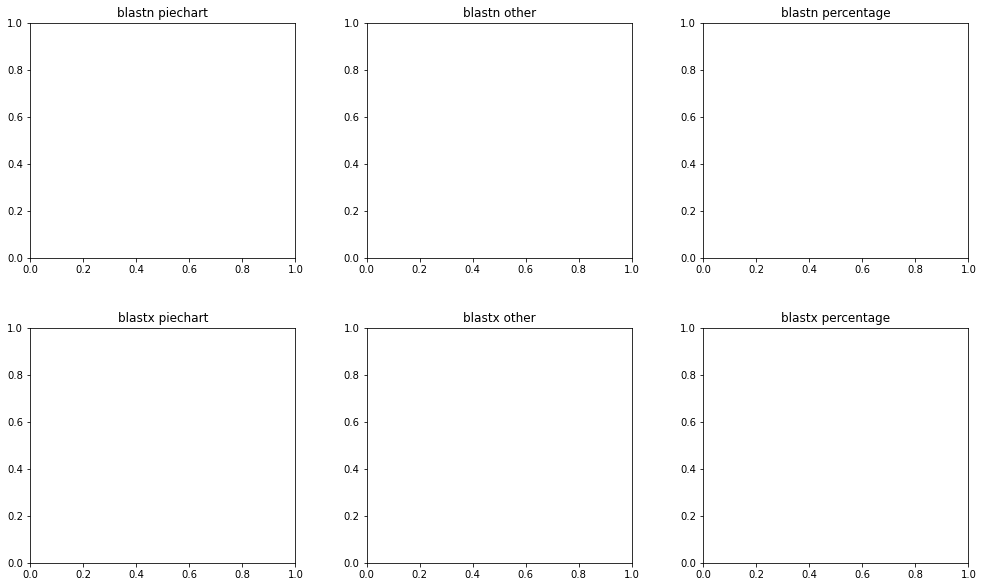

In [37]:
#select intepreter and change environment to anaconda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import xmltodict
from xml.dom import minidom
import time


#handles command line input parameter
import sys
import os

# testing file is from 10,000 reads, so mapping percentage is expected to be out of 10 mil
blast_tsv_file = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastn.tsv'
blast_tsv_file2 = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastx.tsv'
piePath = 'Combined.png'
piePathSample = os.path.splitext(piePath)[0]
piePathSample2 = os.path.split(piePathSample)
pieName = piePathSample2[1]

#ncbi query functions
def esearch(term, db='gds'):
    """
    Queries NCBI using the esearch utility. GEO ('gds') database is used as default for search term.
    """
    url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db={db}&term={term}&retmax=5000&usehistory=y'
    response = urllib.request.urlopen(url)
    return response.read()


def get_esummary(esearch_string, db='gds'):
    """
    Parses a http response in XML format to obtain the webenv and querykey tokens.
    Uses NCBI eutils to transform these tokens into web summaries of GEO (db='gds') datasets.
    """
    xmldoc = minidom.parseString(esearch_string)
    try:
        webenv = xmldoc.getElementsByTagName('WebEnv')[0].firstChild.data
        querykey = xmldoc.getElementsByTagName('QueryKey')[0].firstChild.data
        host = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi'
        params = f'?db={db}&version=2.0&query_key={querykey}&WebEnv={webenv}'
        url = host + params
        response = urllib.request.urlopen(url)
        return response.read()
    except IndexError as e:
        print(f"Unparsable publication string ({e}, search={esearch_string}")
        return ""

#matplotlib to build the piechart
fig, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, figsize=(9, 5))
fig.tight_layout(h_pad=2)
plt.subplots_adjust(bottom=0, right=1.5, top=1.5)
ax1.set_title('blastn piechart')
ax2.set_title('blastn other')
ax3.set_title('blastx piechart')
ax4.set_title('blastx other')
ax5.set_title('blastn percentage')
ax6.set_title('blastx percentage')





# Read the blast n file
df = pd.read_csv(blast_tsv_file, header=None, sep='\t')
df.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

df2 = df[['qseqid','sseqid','evalue']].copy()

# Read the blast x file
df4 = pd.read_csv(blast_tsv_file2, header=None, sep='\t')
df4.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']




# ### still need to reorganize the code for each different file below.


# #blast n output default is by best hit/lowest e value score, therefore add the first sseqid result for each qseqid
# sseqid_list1 = []
# qseqid_list1 = []
# for idx in df.index:
#         if df['qseqid'][idx] not in qseqid_list1:
#                 qseqid_list1.append(df['qseqid'][idx])
#                 sseqid_list1.append(df['sseqid'][idx])
# sseqid_np1 = np.array(sseqid_list1)

# #blast x output default is by best hit/lowest e value score, therefore add the first sseqid result for each qseqid
# sseqid_list2 = []
# qseqid_list2 = []
# for idx in df4.index:
#         if df4['qseqid'][idx] not in qseqid_list2:
#                 qseqid_list2.append(df4['qseqid'][idx])
#                 sseqid_list2.append(df4['sseqid'][idx])
# sseqid_np2 = np.array(sseqid_list2)

# df3 = pd.DataFrame(data = sseqid_np1, columns=['sseqid'])
# print(df3)
# num_seqs = df3.size
# df5 = pd.DataFrame(data = sseqid_np2, columns=['sseqid'])
# print(df5)
# num_seqs2 = df5.size

# sseq_count_series1 = df3['sseqid'].value_counts()
# print(sseq_count_series1)

# sseq_count_series4 = df5['sseqid'].value_counts()
# print(sseq_count_series4)

# #loop through series to determine which elements to remove and add into "other" column
# to_remove1 = []
# other_count1 = 0
# otherDict1 = {}
# to_remove2 = []
# other_count2 = 0
# otherDict2 = {}

# #blastn number mapped
# print(num_seqs)

# #blastx number mapped
# print(num_seqs2)

# #taking 1% of number of sequences for blast n
# only_2_n = 2
# for index,values in sseq_count_series1.iteritems():
#         if(values < (0.001)*(num_seqs)) or only_2_n == 0:
#                 to_remove1.append(index)
#                 other_count1 += values
#                 otherDict1[values] = index
#         else:
#             only_2_n -= 1

# #taking 1% of number of sequences for blast x
# only_2_x = 2
# for index,values in sseq_count_series4.iteritems():
#         if(values < (0.001)*(num_seqs2)) or only_2_x == 0:
#                 to_remove2.append(index)
#                 other_count2 += values
#                 otherDict2[values] = index
#         else:
#             only_2_x -= 1

# otherAnswer1 = []
# increment1 = 0
# for key,value in sorted(otherDict1.items(),reverse=True):
#         if increment1 <= 2:
#                 otherAnswer1.append((key,value))
#                 increment1+=1
#         else:
#              break              
                
# otherAnswer2 = []
# increment2 = 0
# for key,value in sorted(otherDict2.items(),reverse=True):
#         if increment2 <= 2:
#                 otherAnswer2.append((key,value))
#                 increment2+=1
#         else:
#              break

# gene_ratios = []
# gene_labels = []  
# gene_labels_raw = []  

# for idx in range(len(otherAnswer1)):
#         gene_ratios.append(otherAnswer1[idx][0]/other_count1)
#         gene_labels_raw.append(otherAnswer1[idx][1])

# #replace index sseqids with ncbi name
# for idx in range(len(gene_labels_raw)):
#         term = str(gene_labels_raw[idx])
#         print(term)
#         esearch_string = esearch(term=term, db='nucleotide')
#         time.sleep(0.1)
#         result = get_esummary(esearch_string=esearch_string, db='nucleotide')
#         result = xmltodict.parse(result)
#         sseq_name = result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
#         gene_labels.append(sseq_name)                          
                
# gene_ratios2 = []
# gene_labels2 = []
# gene_labels_raw2 = []

# for idx in range(len(otherAnswer2)):
#         gene_ratios2.append(otherAnswer2[idx][0]/other_count2)
#         gene_labels_raw2.append(otherAnswer2[idx][1])

# #replace index sseqids with ncbi name
# for idx in range(len(gene_labels_raw2)):
#         term = str(gene_labels_raw2[idx])
#         print(term)
#         esearch_string = esearch(term=term, db='protein')
#         time.sleep(0.3)
#         result = get_esummary(esearch_string=esearch_string, db='protein')
#         result = xmltodict.parse(result)
#         sseq_name = result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
#         gene_labels2.append(sseq_name) 
               
                

# #remove these elements from series
# sseq_count_series2 = sseq_count_series1.drop(to_remove1)
# sseq_count_series5 = sseq_count_series4.drop(to_remove2)

# sseq_name_list = []
# sseqid = []
# #replace index sseqids with ncbi name
# for index,values in sseq_count_series2.iteritems():
#         sseqid.append(index)
#         term = str(index)
#         esearch_string = esearch(term=term, db='nucleotide')
#         time.sleep(0.1)
#         result = get_esummary(esearch_string=esearch_string, db='nucleotide')
#         result = xmltodict.parse(result)
#         sseq_name = result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
#         sseq_name_list.append(sseq_name)
#         #sseq_count_series2.rename(index={index:sseq_name})
# #replace the sseqids with ncbi query names
# replacements = {sseqid:sseq_name_list for sseqid, sseq_name_list in zip(sseqid, sseq_name_list)}
# sseq_count_series3 = sseq_count_series2.rename(replacements)
# #sseq_count_series2 = sseq_count_series2.rename(index=dict(zip(sseq_name_list,sseqid)))

# #generate new pandas series with new element to concatenate with old series
# d = {'Other':other_count1}
# ser = pd.Series(data=d, index=['Other'])

# #append new element
# sseq_count = sseq_count_series3.append(ser)
# #print(sseq_count)

# #value_counts returns a pandas series so convert to a data frame
# sseq_count_df = pd.DataFrame({'sseqid':sseq_count.index, 'count':sseq_count.values})
# print(sseq_count_df)

# count = sseq_count_df['count']
# sseq = sseq_count_df['sseqid']



# sseq_name_list2 = []
# sseqid2 = []
# #replace index sseqids with ncbi name
# for index,values in sseq_count_series5.iteritems():
#         sseqid2.append(index)
#         term = str(index)
#         esearch_string = esearch(term=term, db='protein')
#         time.sleep(0.1)
#         result = get_esummary(esearch_string=esearch_string, db='protein')
#         result = xmltodict.parse(result)
#         sseq_name = result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
#         sseq_name_list2.append(sseq_name)
#         #sseq_count_series2.rename(index={index:sseq_name})
# #replace the sseqids with ncbi query names
# replacements2 = {sseqid2:sseq_name_list2 for sseqid2, sseq_name_list2 in zip(sseqid2, sseq_name_list2)}
# sseq_count_series6 = sseq_count_series5.rename(replacements2)
# #sseq_count_series2 = sseq_count_series2.rename(index=dict(zip(sseq_name_list,sseqid)))

# #generate new pandas series with new element to concatenate with old series
# d2 = {'Other':other_count2}
# ser2 = pd.Series(data=d2, index=['Other'])

# #append new element
# sseq_count2 = sseq_count_series6.append(ser2)
# #print(sseq_count)

# #value_counts returns a pandas series so convert to a data frame
# sseq_count_df2 = pd.DataFrame({'sseqid':sseq_count2.index, 'count':sseq_count2.values})
# print(sseq_count_df2)

# count2 = sseq_count_df2['count']
# sseq2 = sseq_count_df2['sseqid']

# bottom = 1
# width = 0.2

# wedges1, *_ = ax1.pie(count, labels = sseq, colors=None,autopct='%1.1f%%',startangle=45,
#         wedgeprops={"linewidth": 1, "edgecolor": "white"})

# for j, (height, label) in enumerate(reversed([*zip(gene_ratios, gene_labels)])):
#     bottom -= height
#     bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
#                  alpha=0.1 + 0.25 * j)
#     ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

# # ax2.set_title('Other unmapped reads')
# ax2.legend()
# ax2.axis('off')
# ax2.set_xlim(- 2.5 * 2, 2.5 * 2)



# bottom = 1
# width = 0.2

# wedges2, *_ = ax3.pie(count2, labels = sseq2, colors=None,autopct='%1.1f%%',startangle=45,
#         wedgeprops={"linewidth": 1, "edgecolor": "white"})

# for j, (height, label) in enumerate(reversed([*zip(gene_ratios2, gene_labels2)])):
#     bottom -= height
#     bc = ax4.bar(0, height, width, bottom=bottom, color='C0', label=label,
#                  alpha=0.1 + 0.25 * j)
#     ax4.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')
    
# # ax4.set_title('Other unmapped reads')
# ax4.legend()
# ax4.axis('off')
# ax4.set_xlim(- 2.5 * 2, 2.5 * 2)




# ### Get the percentage of the the blast n/x mapped results
# # for ax5
# ax5_percentages = [200 - num_seqs, num_seqs]
# ax5_labels = ['Unmapped', 'Mapped']
# ax5.pie(ax5_percentages, labels=ax5_labels, autopct='%1.1f%%',
#        colors=['skyblue', 'gray'], labeldistance=1.1)

# # for ax6
# ax6_percentages = [200 - num_seqs2, num_seqs2]
# ax6_labels = ['Unmapped', 'Mapped']
# ax6.pie(ax6_percentages, labels=ax6_labels, autopct='%1.1f%%',
#        colors=['skyblue', 'gray'], labeldistance=1.1)

# # Adding Circle in Pie chart
# circle1 = plt.Circle((0, 0), radius=0.6, color='white')
# ax5.add_patch(circle1)
# circle2 = plt.Circle((0, 0), radius=0.6, color='white')
# ax6.add_patch(circle2)

# text1 = str(num_seqs) + " out of 10000 sequences no mapping"
# text2 = str(num_seqs2) + " out of 10000 sequences no mapping"

# # plt.title('Blastn and Blastx Unmapped Sequences Summary ' + pieName)
# ax5.text(0.95, 2.2, text1, transform=ax6.transAxes, fontsize=14,
#         verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
# ax6.text(0.95, 0.95, text2, transform=ax6.transAxes, fontsize=14,
#         verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

# fig.tight_layout(pad=5.0)
# plt.show(block=True)
# plt.savefig(piePath,format='png',bbox_inches='tight')


In [18]:
dictionary = {}
for eachid,eachp in zip(df['sseqid'], df['pident']):
    if eachid not in dictionary:
        dictionary[eachid] = [eachp, 1]
    elif float(eachp) > dictionary[eachid][0]:
        dictionary[eachid] = [float(eachp), 1]
    elif float(eachp) == dictionary[eachid][0]:
        dictionary[eachid][1] += 1

dictionary = sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
print(dictionary[0])
print(dictionary[1])
print(dictionary[2])

('OV277454.1', [100.0, 48302])
('XR_006701964.1', [100.0, 31441])
('XR_006701925.1', [100.0, 31377])


In [44]:
term = 'PCO95652.1'

#term = str(index)
esearch_string = esearch(term=term, db='protein')
time.sleep(0.1)
result = get_esummary(esearch_string=esearch_string, db='protein')
result = xmltodict.parse(result)
sseq_name = result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
print(sseq_name)

hypothetical protein CP996_26250 [Escherichia coli]


In [31]:
dictionary2 = {}
for eachid,eachp in zip(df4['sseqid'], df4['pident']):
    if eachid not in dictionary2:
        dictionary2[eachid] = [eachp, 1]
    elif float(eachp) > dictionary2[eachid][0]:
        dictionary2[eachid] = [float(eachp), 1]
    elif float(eachp) == dictionary2[eachid][0]:
        dictionary2[eachid][1] += 1
        
dictionary2 = sorted(dictionary2.items(), key=lambda x:x[1], reverse=True)
for each in dictionary2:
    if float(each[1][0]) == float(100):
        print(each[0])

XP_023382753.1
KAI4560734.1
KAI4552411.1
KAG5196993.1
KAF4017913.1
KAI4532776.1
VDK21398.1
CBA31922.1
VBC09016.1
ELW62073.1
EGG54220.1
BAO87435.1
OIC39171.1
CAG7733208.1
PCQ40107.1
RJF55190.1
CAB5278206.1
RJF56792.1
KAH0292783.1
KAG9957943.1
KAG9650917.1
KAG9990601.1
KAG9511838.1
KAH1280767.1
PCO95652.1
EFX63797.1
KAF1858216.1
KAF1858446.1
KAF1858249.1
CBA31932.1
CDW93817.1
TDM08366.1
PZB75107.1
CBA31936.1
BAO86772.1
CBA31918.1
GEU28357.1
KAF1858403.1
CBA31924.1
KMS65245.1
EGG54221.1
CBA31926.1
EER60171.1
EER59998.1
CAB5155272.1
BAG46935.1
WP_216361114.1
KAG7527217.1
ORY20336.1
GAN72223.1
KAF1854097.1
GBQ32694.1
CBA31934.1
GIX54970.1
BAO82212.1
EJC97563.1
KDR65242.1
XP_006458830.1
KAF1858456.1
SOZ25704.1
KAF1858529.1
ANT01126.1
VDO57626.1
BAD90390.1
PVH67537.1
KAE9362521.1
TVY13322.1
KAH8743916.1
KAH8743556.1
DAA31426.1
AGC71898.1
Q5DU56.2
OIE11131.1
KRZ48507.1
EFX63806.1
AAS66225.1
WP_211775587.1
KAI3477533.1
ABM53544.1
KRY64375.1
AAP92618.1
XP_041598321.1
CCG20003.1
XP_037690726.1
CD

In [3]:
#select intepreter and change environment to anaconda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import xmltodict
from xml.dom import minidom
import time


#handles command line input parameter
import sys
import os

# testing file is from 10,000 reads, so mapping percentage is expected to be out of 10,000
blast_tsv_file = "fiftyX.tsv"
#blast_tsv_file2 = sys.argv[2]
#piePath = sys.argv[3]
#piePathSample = os.path.splitext(piePath)[0]
#piePathSample2 = os.path.split(piePathSample)
#pieName = piePathSample2[1]
filterlist = ['bacter', 'bacterium', 'strain', 'Homo sapiens', 'Mus musculus', 'virus']

#ncbi query functions
def esearch(term, db='gds'):
    """
    Queries NCBI using the esearch utility. GEO ('gds') database is used as default for search term.
    """
    url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db={db}&term={term}&retmax=5000&usehistory=y'
    response = urllib.request.urlopen(url)
    return response.read()


def get_esummary(esearch_string, db='gds'):
    """
    Parses a http response in XML format to obtain the webenv and querykey tokens.
    Uses NCBI eutils to transform these tokens into web summaries of GEO (db='gds') datasets.
    """
    xmldoc = minidom.parseString(esearch_string)
    try:
        webenv = xmldoc.getElementsByTagName('WebEnv')[0].firstChild.data
        querykey = xmldoc.getElementsByTagName('QueryKey')[0].firstChild.data
        host = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi'
        params = f'?db={db}&version=2.0&query_key={querykey}&WebEnv={webenv}'
        url = host + params
        response = urllib.request.urlopen(url)
        return response.read()
    except IndexError as e:
        print(f"Unparsable publication string ({e}, search={esearch_string}")
        return ""


# Read the blast n file
df = pd.read_csv(blast_tsv_file, header=None, sep='\t')
df.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

df2 = df[['qseqid','sseqid','pident']].copy()

# Read the blast x file
#df3 = pd.read_csv(blast_tsv_file2, header=None, sep='\t')
#df3.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']
#df4 = df3[['qseqid','sseqid','pident']].copy()

dictionary1 = {}
for eachid,eachp in zip(df2['sseqid'], df2['pident']):
    if eachid not in dictionary1:
        dictionary1[eachid] = [eachp, 1]
    elif float(eachp) > dictionary1[eachid][0]:
        dictionary1[eachid] = [float(eachp), 1]
    elif float(eachp) == dictionary1[eachid][0]:
        dictionary1[eachid][1] += 1

dictionary1 = sorted(dictionary1.items(), key=lambda x:x[1], reverse=True)
ncbilist1 = []

for each in dictionary1:
    if float(each[1][0]) == float(100):
        checker = 0
        term = str(each[0])
        #print(term)
        esearch_string = esearch(term=term, db='protein')
        time.sleep(0.1)
        result = get_esummary(esearch_string=esearch_string, db='protein')
        result = xmltodict.parse(result)
        #print(result)
        if 'eSummaryResult' not in result:
            continue
        elif 'DocumentSummarySet' not in result['eSummaryResult']:
            continue
        elif 'DocumentSummary' not in result['eSummaryResult']['DocumentSummarySet']:
            continue
        elif 'Title' not in result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']:
            continue
        else:
            sseq_name = result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
        for i in range(len(filterlist)):
            if filterlist[i] in sseq_name:
                ncbilist1.append(sseq_name)

blastnSort1 = pd.DataFrame(ncbilist1, columns=['Name'])
blastnSort2 = blastnSort1['Name'].value_counts()
print(blastnSort2)

HTTPError: HTTP Error 429: Too Many Requests

In [ ]:
#select intepreter and change environment to anaconda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import xmltodict
from xml.dom import minidom
import time


#handles command line input parameter
import sys
import os

# testing file is from 10,000 reads, so mapping percentage is expected to be out of 10,000
blast_tsv_file = 'LARP6.TGFb_IN1.umi.r1.fq_unmappedblast_downsampled_blastn.tsv'
#blast_tsv_file2 = sys.argv[2]
#piePath = sys.argv[3]
#piePathSample = os.path.splitext(piePath)[0]
#piePathSample2 = os.path.split(piePathSample)
#pieName = piePathSample2[1]
filterlist = ['bacter', 'bacterium', 'strain', 'Homo sapiens', 'Mus musculus', 'virus']

def esearch(term, db='gds', api_key='9e09d5d38c680a8358426f7fac6d154b4f08'):
    """
    Queries NCBI using the esearch utility. GEO ('gds') database is used as default for search term.
    """
    url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db={db}&term={term}&retmax=5000&usehistory=y&api_key={api_key}'
    try:
        response = urllib.request.urlopen(url)
    except urllib.error.HTTPError:
        return 'No_Species'        
    return response.read()


def get_esummary(esearch_string, db='gds', api_key='9e09d5d38c680a8358426f7fac6d154b4f08'):
    """
    Parses a http response in XML format to obtain the webenv and querykey tokens.
    Uses NCBI eutils to transform these tokens into web summaries of GEO (db='gds') datasets.
    """
    xmldoc = minidom.parseString(esearch_string)
    try:
        webenv = xmldoc.getElementsByTagName('WebEnv')[0].firstChild.data
        querykey = xmldoc.getElementsByTagName('QueryKey')[0].firstChild.data
        host = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi'
        params = f'?db={db}&version=2.0&query_key={querykey}&WebEnv={webenv}&api_key={api_key}'
        url = host + params
        response = urllib.request.urlopen(url)
        return response.read()
    except IndexError as e:
        print(f"Unparsable publication string ({e}, search={esearch_string}")
        return ""


def ncbi_parse(result):
    try:
        return result['eSummaryResult']['DocumentSummarySet']['DocumentSummary']['Title']
    except TypeError:
        return 'No_Species'
    except KeyError:
        return 'No_Species'

# # Read the blast n file
# df = pd.read_csv(blast_tsv_file, header=None, sep='\t')
# df.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']

# df2 = df[['qseqid','sseqid','pident']].copy()

# # Read the blast x file
# #df3 = pd.read_csv(blast_tsv_file2, header=None, sep='\t')
# #df3.columns = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']
# #df4 = df3[['qseqid','sseqid','pident']].copy()

# dictionary1 = {}
# for eachid,eachp in zip(df2['sseqid'], df2['pident']):
#     if eachid not in dictionary1:
#         dictionary1[eachid] = [eachp, 1]
#     elif float(eachp) > dictionary1[eachid][0]:
#         dictionary1[eachid] = [float(eachp), 1]
#     elif float(eachp) == dictionary1[eachid][0]:
#         dictionary1[eachid][1] += 1

# dictionary1 = sorted(dictionary1.items(), key=lambda x:x[1], reverse=True)

# checkqseqid = []
# dict1 = {}
# for eachqid,eachsid,eachp in zip(df2['qseqid'],df2['sseqid'],df2['pident']):
#     if eachqid not in checkqseqid:
#         #first instance of qseqid encountered, add top hit
#         checkqseqid.append(eachqid)
#         if eachsid not in dict1:
#             dict1[eachsid] = 1
#         else:
#            dict1[eachsid] += 1
#         continue
#     #not the first hit for the qseqid
#     if eachp == 100:
#         if eachsid not in dict1:
#             dict1[eachsid] = 1
#         else:
#             dict1[eachsid] += 1
#     else:
#         #ignore if the score is less than 100 until next qseqid is reached
#         continue

# qseqidDf = pd.DataFrame(list(dict1.items()), columns=['qseqid','frequency'])
# qseqidDf.to_csv('temp_unfilter_qseqidDf.csv', index=False)
#filter by frequency if frequency is too small TODO
qseqidDf = pd.read_csv('temp_unfilter_qseqidDf.csv')

toDrop = []
#filter by keywords!
for index,row in qseqidDf.iterrows():
    term = str(row['qseqid'])
    esearch_string = esearch(term=term, db='nucleotide')
    if (esearch_string == 'No_Species'):
        print('oh noooooo')
        continue
    time.sleep(0.7)
    result = get_esummary(esearch_string=esearch_string, db='nucleotide')
    result = xmltodict.parse(result)
    sseq_name = ncbi_parse(result)
    found = False
    for i in range(len(filterlist)):
        if filterlist[i] in sseq_name:
            qseqidDf.loc[index, 'qseqid'] = sseq_name
            found = True
    if found == False:
        toDrop.append(index)

for i in range(len(toDrop)):
    qseqidDf.drop(toDrop[i])

qseqidDf.to_csv('qseqidDf.csv', index=False)

In [19]:
import pandas as pd
qseqidDf = pd.read_csv('qseqidDf.csv')

filterlist = ['bacter', 'bacterium', 'strain', 'Homo sapiens', 'Mus musculus', 'virus']
toDrop = []

for index,row in qseqidDf.iterrows():
    found = False
    for i in range(len(filterlist)):
        if filterlist[i] in row['qseqid']:
            found = True
    if found == False:
        toDrop.append(index)

for i in range(len(toDrop)):
    qseqidDf = qseqidDf.drop(toDrop[i])
qseqidDf


,qseqid,frequency
0,Uncultured bacterium clone F5K2Q4C04ILFGP 23S ...,11
7,Homo sapiens FOSMID clone ABC12-47014600B1 fro...,1
22,"Mus musculus chromosome 3, clone RP23-215I1, c...",175
24,"Homo sapiens RNA, 5S ribosomal pseudogene 202 ...",10124
25,Aureobasidium pullulans strain CMIFS 003 large...,20
...,...,...
16814,"Homo sapiens ring finger protein 213 (RNF213),...",1
16815,Homo sapiens BAC clone CH17-343P10 from chromo...,1
16817,Synthetic construct Homo sapiens clone ccsbBro...,1
16819,"Homo sapiens cDNA FLJ45902 fis, clone OCBBF302...",1
